# Лабораторная работа № 8
## Динамические сети

### Воронов К.М., М8О-407Б-19

Целью работы является исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.


 Вариант 19

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from torch.utils.data import DataLoader

In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class TDL(nn.Module):
    def __init__(self, in_dim, delays):
        super(TDL, self).__init__()
        self.in_dim = in_dim
        self.delays = delays
        self.queue = deque()
        self.clear()
        
    def clear(self):
        self.queue.clear()
        for i in range(self.delays):
            self.queue.append(torch.zeros(self.in_dim))
        

    def push(self, inputs):
        self.queue.appendleft(inputs)

    def forward(self, input = 0):
        return self.queue.pop()

In [ ]:
class NARX(nn.Module):
    def __init__(self, in_dim, hi_dim, out_dim, delays1, delays2):
        super(NARX, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hi_dim = hi_dim

        self.queue1 = TDL(in_dim, delays1)
        self.queue2 = TDL(out_dim, delays2)

        self.w1 = torch.nn.Parameter(torch.randn(in_dim, hi_dim))
        self.w2 = torch.nn.Parameter(torch.randn(hi_dim, out_dim))
        self.w3 = torch.nn.Parameter(torch.randn(out_dim, hi_dim))

        self.b1 = torch.nn.Parameter(torch.ones(hi_dim))
        self.b2 = torch.nn.Parameter(torch.ones(out_dim))

    def clear(self):
        self.queue1.clear()
        self.queue2.clear()

    def forward(self, inputs):
        out1 = torch.tanh(self.queue1() @ self.w1 + self.queue2() @ self.w3 + self.b1)
        out2 = out1 @ self.w2 + self.b2

        self.queue1.push(torch.tensor(inputs))
        self.queue2.push(torch.tensor(out2))

        return out2

In [ ]:
def fun_u(k):
    return np.cos(k * k - 10 * k + 3)

def fun_y(yk, uk):
    return yk / (1 + yk ** 2) + uk ** 3

In [ ]:
window_size = 3

narx = NARX(window_size, 24, window_size, 2, 2)

batch_size = 1
epochs = 500
optim = torch.optim.Adam(narx.parameters(), lr = 1e-4)
N = 600

tt = np.linspace(0, 5, N)
u = fun_u(tt)
y = [0]

for i in range(N - 1):
    y.append(fun_y(y[i], u[i]))

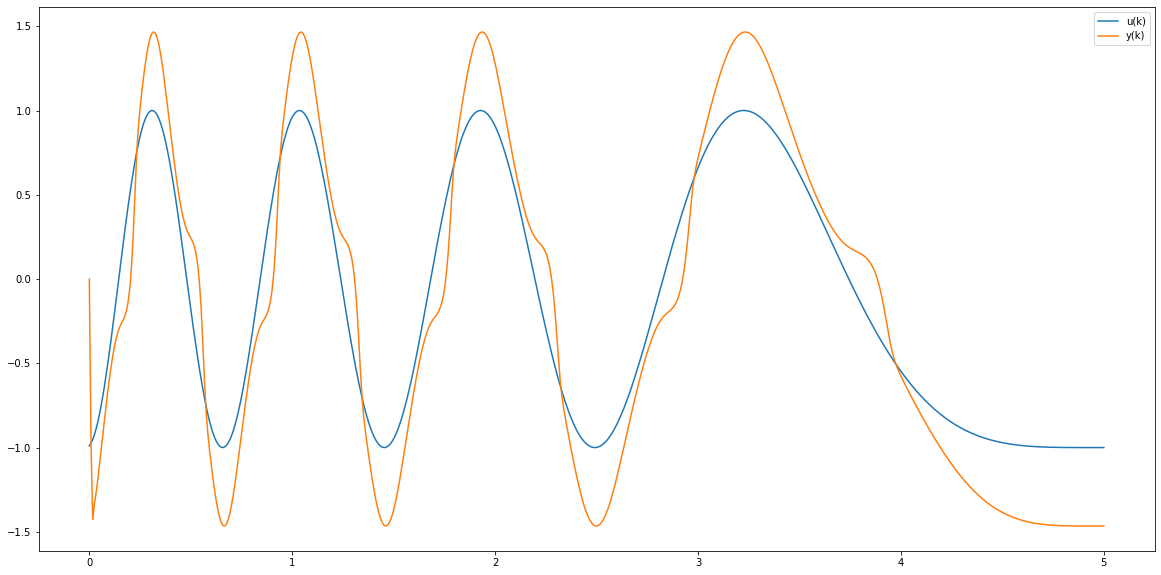

In [ ]:
figure = plt.figure(figsize = (20, 10))

plt.plot(tt, u, label = 'u(k)')
plt.plot(tt, y, label = 'y(k)')
plt.legend()
plt.show()

In [ ]:
data = [(np.array(u[i:i + window_size], dtype = np.float32), np.array(y[i:i + window_size], dtype = np.float32)) for i in range(N - window_size + 1)]
data = DataLoader(data, batch_size = batch_size, shuffle = False)

In [ ]:
narx.train()
loss_epoch = []

for i in range(epochs):

    narx.clear()
    loss_1e = 0
    for x, lbl in data:

        out = narx(x)
        loss = nn.MSELoss()(out, lbl)
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_1e += loss.clone().detach().item()
    
    loss_epoch.append(loss_1e / (N - window_size))
    print("Loss ", i + 1, " = ", loss_epoch[-1])




<ipython-input-97-bd93cde4178f>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.queue1.push(torch.tensor(inputs))
<ipython-input-97-bd93cde4178f>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.queue2.push(torch.tensor(out2))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss  1  =  0.09938914751769722
Loss  2  =  0.07024632064602025
Loss  3  =  0.057242301936405095
Loss  4  =  0.05270695570977404
Loss  5  =  0.05009273008527302
Loss  6  =  0.04768173095913603
Loss  7  =  0.04558422845900718
Loss  8  =  0.04366181677527907
Loss  9  =  0.041875504201509754
Loss  10  =  0.04025777700846395
Loss  11  =  0.038839532887373275
Loss  12  =  0.03761669714413302
Loss  13  =  0.03655051127723624
Loss  14  =  0.03560030473459265
Loss  15  =  0.03474151103480811
Loss  16  =  0.033963635486167064
Loss  17  =  0.03326193149679518
Loss  18  =  0.032632069482788455
Loss  19  =  0.032068489427023866
Loss  20  =  0.03156446781026693
Loss  21  =  0.03111274039894526
Loss  22  =  0.030705460063021918
Loss  23  =  0.030334137732781614
Loss  24  =  0.02999061415320706
Loss  25  =  0.029668120244211577
Loss  26  =  0.02936154064827952
Loss  27  =  0.029067181188106566
Loss  28  =  0.028782967033520963
Loss  29  =  0.02850701201070594
Loss  30  =  0.028238689982327123
Loss  3

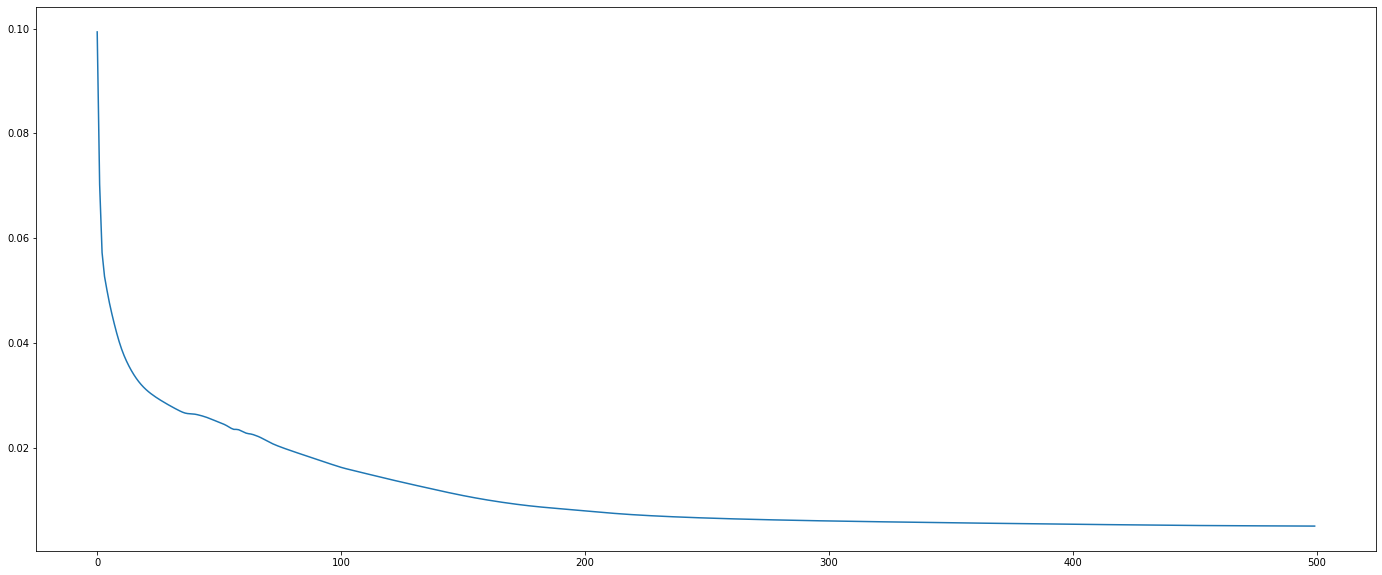

In [ ]:
ttt = np.arange(0, epochs, 1)
figure = plt.figure(figsize = (24, 10))
plt.plot(ttt, loss_epoch)

plt.show()


In [ ]:
narx.eval()
narx.clear()

predict = []

ii = 0
for x, _ in data:
    if ii == 0:
        predict = narx(x).detach().numpy()
    else:
        predict = np.append(predict, narx(x).detach().numpy().item(-1))
    ii = 1


<ipython-input-97-bd93cde4178f>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.queue1.push(torch.tensor(inputs))
<ipython-input-97-bd93cde4178f>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.queue2.push(torch.tensor(out2))


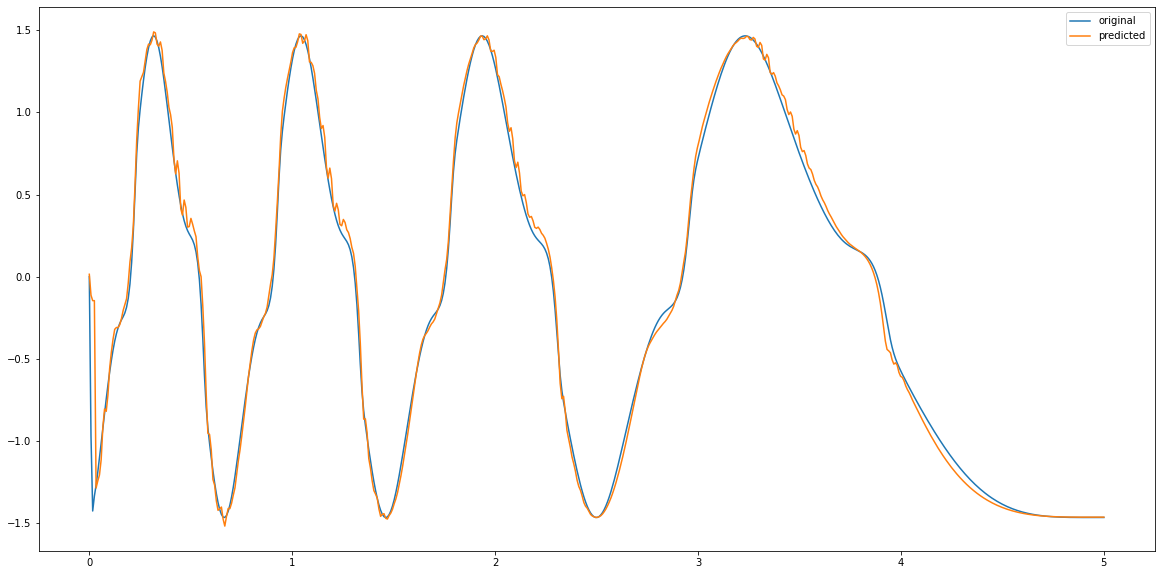

In [ ]:
figure = plt.figure(figsize = (20, 10))

plt.plot(tt, y, label = 'original')
plt.plot(tt, predict, label = 'predicted')
plt.legend()
plt.show()

# Выводы
Выполнив данную лабораторную работу, я изучил строение сетей NARX и реализовал одну из них, продемонстрировав её работу на предсказывании значения функции по значениям другой функции.